In [3]:
import keras
import random
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

In [5]:
from imblearn.over_sampling import SMOTE

In [6]:
from imblearn.under_sampling import RandomUnderSampler

In [7]:
train_data = pd.read_pickle('train_data_mutual_info_classif.pkl')

In [8]:
train_data.head()

,ProductCD,card3,card4,card6,addr2,R_emaildomain,D12,D13,M1,M2,M3,M4,M5,M7,M8,M9,V18,V30,V40,V60,V70,V80,V81,V91,V173,V174,V223,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_33,id_35,id_36,id_37,DeviceType,DeviceInfo,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,TransactionAmt,isFraud
0,4,42,1,1,65,31,-1.416108,-1.833103,1,1,1,2,0,2,2,2,-0.540222,-0.664176,-0.50417,-0.51961,-0.664404,-0.521953,-0.508172,-0.694394,-1.102703,-1.135389,-1.072947,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.278167,0
1,4,42,2,1,65,31,-1.416108,-1.833103,2,2,2,0,1,2,2,2,-0.540222,-0.664176,-0.50417,-0.51961,-0.664404,-0.521953,-0.508172,-0.694394,-1.102703,-1.135389,-1.072947,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.443327,0
2,4,42,4,2,65,31,-1.416108,-1.833103,1,1,1,0,0,0,0,0,-0.540222,-0.664176,-0.50417,-0.51961,-0.664404,-0.521953,-0.508172,-0.694394,-1.102703,-1.135389,-1.072947,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.317889,0
3,4,42,2,2,65,31,-1.416108,-1.833103,2,2,2,0,1,2,2,2,-0.540222,-0.664176,-0.50417,-0.51961,-0.664404,-0.521953,-0.508172,-0.694394,-0.105190,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.355521,0
4,1,42,2,1,65,31,-1.217018,0.281952,2,2,2,3,2,2,2,2,-0.540222,-0.664176,-0.50417,-0.51961,-0.664404,-0.521953,-0.508172,-0.694394,-1.102703,-1.135389,-1.072947,1,54,1,1,59,400,32,1,1,7,164,1,0,1,2,954,16,24,8,7,249,0,58,-0.355521,0


In [9]:
for col in train_data.columns:
    print(col)

ProductCD
card3
card4
card6
addr2
R_emaildomain
D12
D13
M1
M2
M3
M4
M5
M7
M8
M9
V18
V30
V40
V60
V70
V80
V81
V91
V173
V174
V223
id_12
id_13
id_15
id_16
id_17
id_19
id_20
id_28
id_29
id_30
id_33
id_35
id_36
id_37
DeviceType
DeviceInfo
R_parent_domain
R_domain_name
R_top_level_domain
device_name
device_version
os_name
os_version
TransactionAmt
isFraud


In [10]:
# Feature selection
X = train_data.drop(['isFraud'], axis=1)
y = train_data['isFraud']
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [12]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train_smote.shape)
print(y_train_smote.shape)

(729354, 51)
(729354,)


In [13]:
rus = RandomUnderSampler(random_state=0, sampling_strategy=0.9)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print(X_train_resampled.shape)
print(y_train_resampled.shape)

(28010, 51)
(28010,)


In [14]:
y_train_smote.value_counts(normalize=True)

isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64

In [15]:
y_train_resampled.value_counts(normalize=True)

isFraud
0    0.526312
1    0.473688
Name: proportion, dtype: float64

In [67]:
K.clear_session()

In [28]:
# create a checkpoint callback to save model based on validation recall values
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath="./model/model_reduced_features_baseline/undersampled/base_model_logloss_{val_loss:.2f}_auc_{val_auc:.2f}_checkpoint.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

# create earlystopping callback based on val_recall
early_stopping_callback = EarlyStopping(monitor="val_auc", mode="max", patience=10)


# create a callback list
callbacks = [checkpoint_callback, early_stopping_callback]

# create model function

def create_baseline_model(optimizer):
    # Create a baseline ANN model using keras for predicting binary classes of fraud
    # define ANN model
    model = keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=[X_train_resampled.shape[1]]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # add recall and auc as metrics
    # recall = tf.keras.metrics.Recall(name='recall')
    auc = tf.keras.metrics.AUC(name='auc')

    # compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[auc])

    return model


# Undersampled Data

In [29]:
## Undersampled Data
# choose adam as optimizer
from keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model = create_baseline_model(adam)
history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=512, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 18.4917 - auc: 0.5357
Epoch 1: val_auc improved from -inf to 0.69517, saving model to ./model/model_reduced_features_baseline/undersampled/base_model_logloss_6.58_auc_0.70_checkpoint.h5
55/55 [==============================] - 11s 200ms/step - loss: 18.4917 - auc: 0.5357 - val_loss: 6.5817 - val_auc: 0.6952
Epoch 2/50
51/55 [==========================>...] - ETA: 0s - loss: 10.2585 - auc: 0.5661
Epoch 2: val_auc improved from 0.69517 to 0.69804, saving model to ./model/model_reduced_features_baseline/undersampled/base_model_logloss_6.17_auc_0.70_checkpoint.h5
55/55 [==============================] - 1s 25ms/step - loss: 10.1325 - auc: 0.5655 - val_loss: 6.1746 - val_auc: 0.6980
Epoch 3/50
55/55 [==============================] - ETA: 0s - loss: 6.2623 - auc: 0.5760
Epoch 3: val_auc improved from 0.69804 to 0.71516, saving model to ./model/model_reduced_features_baseline/undersampled/base_model_logloss_2.11_auc_0.72_che

In [30]:
import seaborn as sns

<Axes: xlabel='epoch', ylabel='auc'>

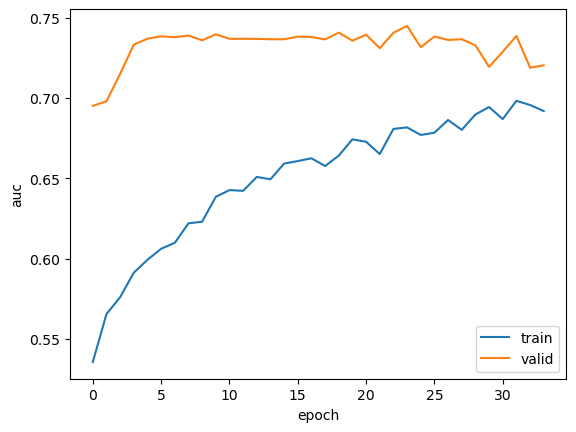

In [31]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [70]:
model_rus = keras.models.load_model('model/model_reduced_features_baseline/undersampled/base_model_logloss_0.97_auc_0.73_checkpoint.h5')

In [71]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt

In [72]:
y_pred_rus = model_rus.predict(X_test)
# using x test here

3691/3691 [==============================] - 6s 1ms/step


In [78]:
y_pred_keras = y_pred_rus.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras_rus = auc(fpr_keras, tpr_keras)
avg_prec_score = average_precision_score(y_test, y_pred_rus)
print(f"AUC for Undersampled: {auc_keras_rus}")
print(f"Average Precision Score for Undersampled: {avg_prec_score}")

AUC for Undersampled: 0.7435025962783847
Average Precision Score for Undersampled: 0.10166180223860835


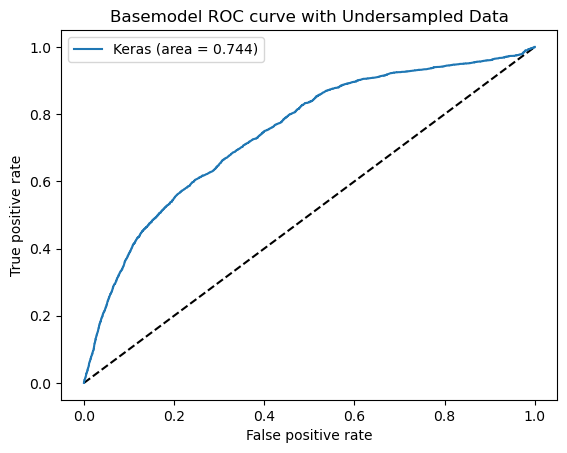

In [74]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Basemodel ROC curve with Undersampled Data')
plt.legend(loc='best')
plt.show()

In [75]:
temp = X_test.copy()
temp['predicted'] = y_pred_rus
temp['true'] = y_test
fraud_cases = temp[temp['true'] == 1]
non_fraud_cases = temp[temp['true']==0]

In [38]:
temp.head()

,ProductCD,card3,card4,card6,addr2,R_emaildomain,D12,D13,M1,M2,M3,M4,M5,M7,M8,M9,V18,V30,V40,V60,V70,V80,V81,V91,V173,V174,V223,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_33,id_35,id_36,id_37,DeviceType,DeviceInfo,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,TransactionAmt,predicted,true
7681,1,42,4,1,65,31,-1.416108,-1.819843,2,2,2,3,2,2,2,2,-0.540222,-0.664176,-0.504170,-0.519610,-0.664404,-0.521953,-0.508172,-0.694394,-1.102703,-1.135389,-1.072947,1,54,0,0,59,389,51,0,0,16,132,1,0,1,0,1769,16,24,8,6,293,3,5,-0.460052,0.079156,0
570242,4,42,2,2,65,31,0.614603,0.533902,1,1,1,0,0,0,0,0,-0.540222,-0.664176,-0.504170,-0.519610,-0.664404,-0.521953,-0.508172,-0.694394,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.075376,0.374459,0
340470,0,73,2,1,43,19,-0.801775,0.533902,2,2,2,2,2,2,2,2,-0.540222,-0.664176,-0.504170,-0.519610,-0.664404,-0.521953,-0.508172,-0.694394,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,15,17,2,13,293,7,68,-0.256120,0.915561,0
131781,2,42,4,1,65,1,0.614603,-1.833103,2,2,2,3,2,2,2,2,1.683197,-0.664176,2.095003,1.524002,-0.664404,1.464129,1.372312,-0.694394,-1.102703,-1.135389,-1.072947,1,38,1,1,59,227,125,1,1,56,14,1,0,1,2,1727,1,1,2,12,293,6,11,1.107920,0.704168,0
472772,4,42,4,2,65,31,0.614603,0.533902,1,1,1,3,2,0,1,1,-0.540222,1.202141,-0.504170,-0.519610,1.204801,-0.521953,-0.508172,1.128298,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.430993,0.298058,0


In [ ]:
# per row consider apakah dia tp, fp, fn, tn dengan bikin 4 kolom
# group by bin
# dihitung cumulative sum untuk setiap tp fp fn tn
# ini berubah seiring threshold berubah
# non-cumulative ngitung precision itu di bin itu doang (bins nya adalah populasi)
# fraud rate
# masukin y_val
# transaksi masuk, kemungkinan dia dihitung fraud berapa? -> fraud rate

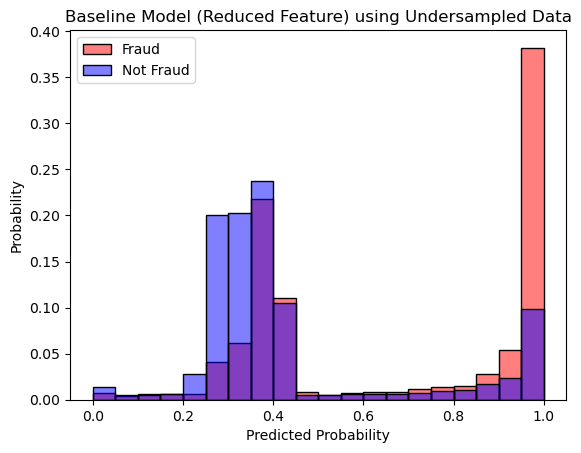

In [76]:
fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Baseline Model (Reduced Feature) using Undersampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

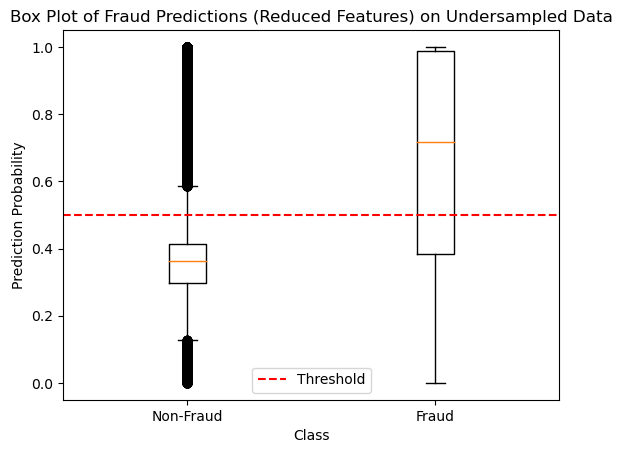

In [77]:
fraud_cases = y_pred_rus[y_test==1]
non_fraud_cases = y_pred_rus[y_test==0]
threshold = 0.5
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions (Reduced Features) on Undersampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Based on this, we can decide that the threshold is 0.39. Let's calculate the confusion matrix

Threshold: 0.41


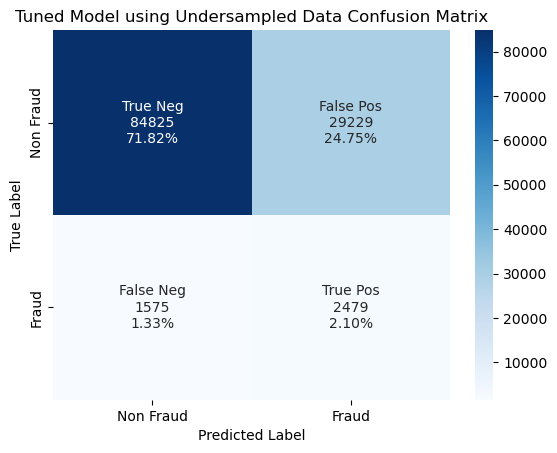

Metrics when threshold is 0.41: 

False Positive Rate: 0.2562733442053764
Recall: 0.6114948199309325
Precision: 0.07818216223035196
Accuracy: 0.739187861956853
F1: 0.13863877859180135
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.42


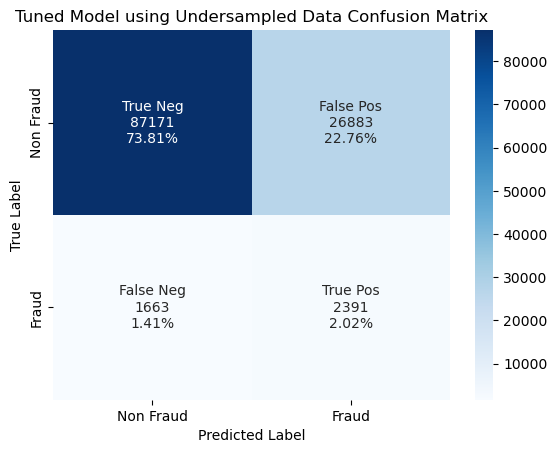

Metrics when threshold is 0.42: 

False Positive Rate: 0.23570414014414226
Recall: 0.5897878638381845
Precision: 0.08167657306825168
Accuracy: 0.7583059572594575
F1: 0.1434829572731637
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.43


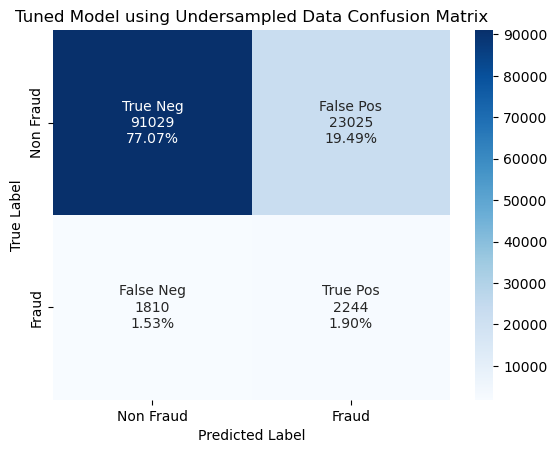

Metrics when threshold is 0.43: 

False Positive Rate: 0.20187805776211268
Recall: 0.5535273803650715
Precision: 0.08880446396770747
Accuracy: 0.7897263521522674
F1: 0.15305391672066296
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.44


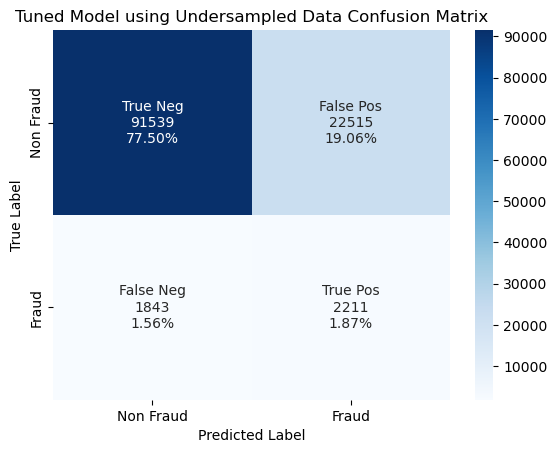

Metrics when threshold is 0.44: 

False Positive Rate: 0.1974064916618444
Recall: 0.5453872718302911
Precision: 0.08942004367871875
Accuracy: 0.7937650286178751
F1: 0.1536483669214732
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.45


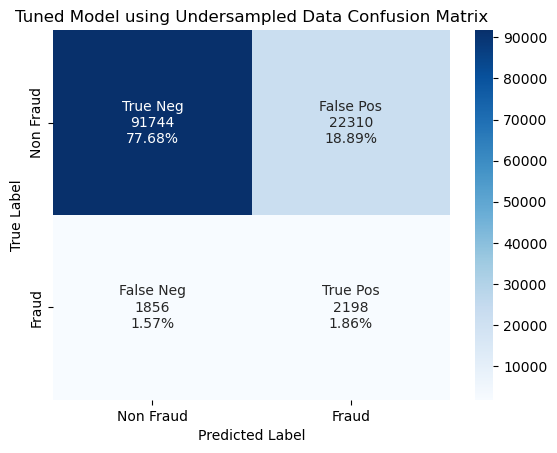

Metrics when threshold is 0.45: 

False Positive Rate: 0.19560909744506988
Recall: 0.5421805624074988
Precision: 0.08968500081606007
Accuracy: 0.7953906593964846
F1: 0.1539107905608851
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.46


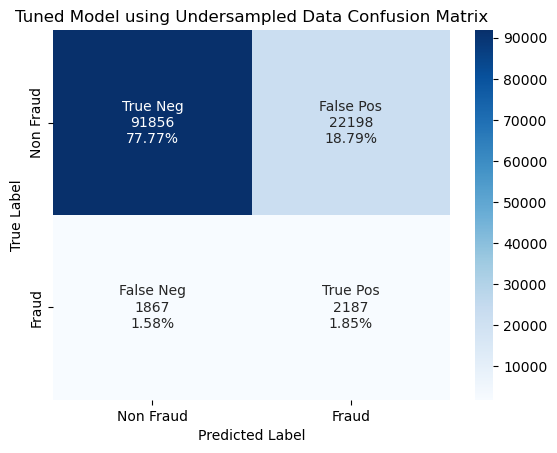

Metrics when threshold is 0.46: 

False Positive Rate: 0.1946271064583443
Recall: 0.5394671928959053
Precision: 0.08968628255074841
Accuracy: 0.7962458089206489
F1: 0.1538028763317979
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.47


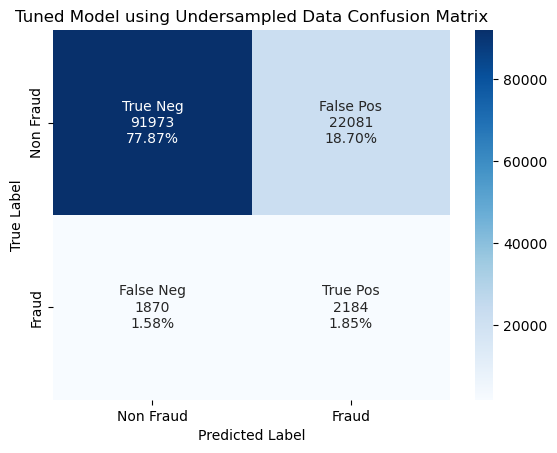

Metrics when threshold is 0.47: 

False Positive Rate: 0.19360127658828274
Recall: 0.538727183029107
Precision: 0.0900061817432516
Accuracy: 0.7972110271954482
F1: 0.15424273455983617
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.48


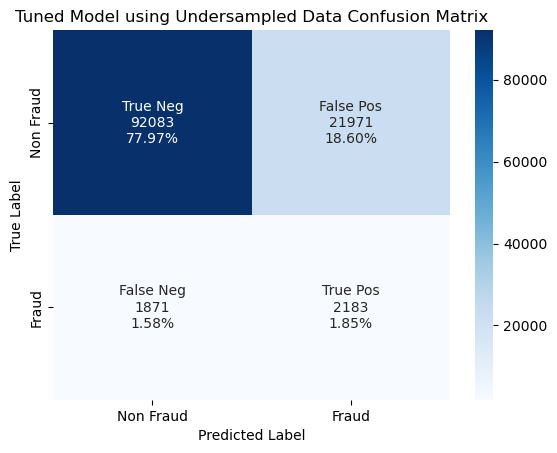

Metrics when threshold is 0.48: 

False Positive Rate: 0.19263682115489153
Recall: 0.5384805130735076
Precision: 0.09037840523308768
Accuracy: 0.7981339113353879
F1: 0.1547787861599546
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.49


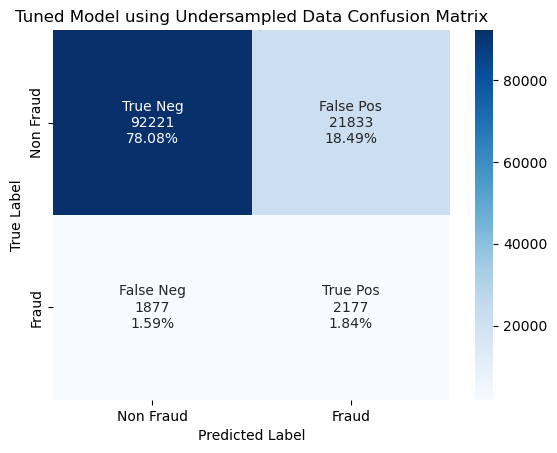

Metrics when threshold is 0.49: 

False Positive Rate: 0.19142686797481895
Recall: 0.5370004933399112
Precision: 0.09067055393586006
Accuracy: 0.7992515324956819
F1: 0.1551453819840365
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835
Threshold: 0.5


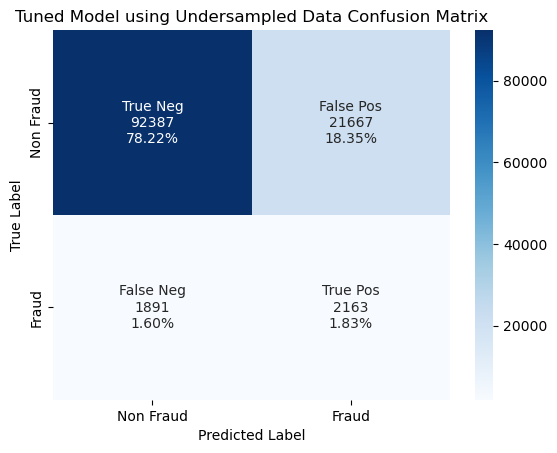

Metrics when threshold is 0.5: 

False Positive Rate: 0.18997141704806494
Recall: 0.5335471139615194
Precision: 0.0907679395719681
Accuracy: 0.8005384901954143
F1: 0.15514273418447852
AUC: 0.7435025962783847
Average Precision Score: 0.10166180223860835


In [79]:
threshold = [0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5]
results = []

for thresh in threshold:
    print(f"Threshold: {thresh}")
    y_pred_binary_rus = (y_pred_rus > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary_rus)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.title("Tuned Model using Undersampled Data Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    avg_prec_score_rus = average_precision_score(y_test, y_pred_rus)

    print(f"Metrics when threshold is {thresh}: ")
    print()
    print(f"False Positive Rate: {fpr}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(f"AUC: {auc_keras_rus}")
    print(f"Average Precision Score: {avg_prec_score_rus}")
    print("="*80)

    result = {
        'Threshold': thresh,
        'False Positive Rate': fpr,
        'Recall': recall,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1,
        'AUC': auc_keras_rus,
    }
    results.append(result)

df_result_rus = pd.DataFrame(results)

In [80]:
df_result_rus

,Threshold,False Positive Rate,Recall,Precision,Accuracy,F1,AUC
0,0.41,0.256273,0.611495,0.078182,0.739188,0.138639,0.743503
1,0.42,0.235704,0.589788,0.081677,0.758306,0.143483,0.743503
2,0.43,0.201878,0.553527,0.088804,0.789726,0.153054,0.743503
3,0.44,0.197406,0.545387,0.089420,0.793765,0.153648,0.743503
4,0.45,0.195609,0.542181,0.089685,0.795391,0.153911,0.743503
5,0.46,0.194627,0.539467,0.089686,0.796246,0.153803,0.743503
6,0.47,0.193601,0.538727,0.090006,0.797211,0.154243,0.743503
7,0.48,0.192637,0.538481,0.090378,0.798134,0.154779,0.743503
8,0.49,0.191427,0.537000,0.090671,0.799252,0.155145,0.743503
9,0.50,0.189971,0.533547,0.090768,0.800538,0.155143,0.743503


In [ ]:
K.clear_session()

# Oversampled

In [53]:
# create a checkpoint callback to save model based on validation recall values
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint(
    filepath="./model/model_reduced_features_baseline/oversampled/base_model_logloss_{val_loss:.2f}_auc_{val_auc:.2f}_checkpoint.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

# create earlystopping callback based on val_recall
early_stopping_callback = EarlyStopping(monitor="val_auc", mode="max", patience=10)


# create a callback list
callbacks = [checkpoint_callback, early_stopping_callback]

# create model function

def create_baseline_model(optimizer):
    # Create a baseline ANN model using keras for predicting binary classes of fraud
    # define ANN model
    model = keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=[X_train_smote.shape[1]]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # add recall and auc as metrics
    # recall = tf.keras.metrics.Recall(name='recall')
    auc = tf.keras.metrics.AUC(name='auc')

    # compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[auc])

    return model


In [54]:
## Oversampled Data
# choose adam as optimizer
from keras.optimizers import Adam
adam = Adam(learning_rate=0.001)
model = create_baseline_model(adam)
history = model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

Epoch 1/50
11397/11397 [==============================] - ETA: 0s - loss: 0.7279 - auc: 0.7458
Epoch 1: val_auc improved from -inf to 0.78661, saving model to ./model/model_reduced_features_baseline/oversampled/base_model_logloss_0.41_auc_0.79_checkpoint.h5
11397/11397 [==============================] - 97s 8ms/step - loss: 0.7279 - auc: 0.7458 - val_loss: 0.4118 - val_auc: 0.7866
Epoch 2/50
11397/11397 [==============================] - ETA: 0s - loss: 0.5264 - auc: 0.8118
Epoch 2: val_auc improved from 0.78661 to 0.78893, saving model to ./model/model_reduced_features_baseline/oversampled/base_model_logloss_0.40_auc_0.79_checkpoint.h5
11397/11397 [==============================] - 90s 8ms/step - loss: 0.5264 - auc: 0.8118 - val_loss: 0.4000 - val_auc: 0.7889
Epoch 3/50
11397/11397 [==============================] - ETA: 0s - loss: 0.5110 - auc: 0.8238
Epoch 3: val_auc improved from 0.78893 to 0.79621, saving model to ./model/model_reduced_features_baseline/oversampled/base_model_logl

<Axes: xlabel='epoch', ylabel='auc'>

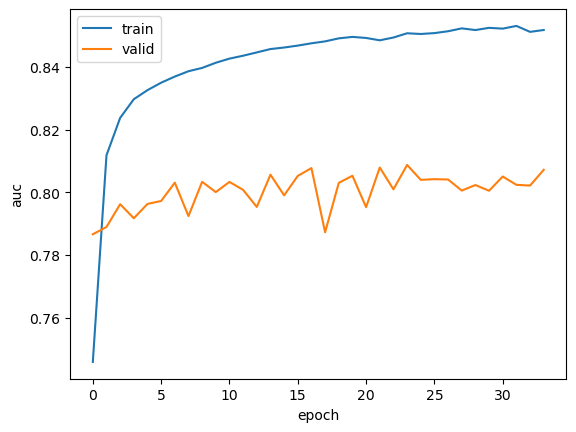

In [55]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch

sns.lineplot(data = history_df, x='epoch', y='auc', label='train')
sns.lineplot(data = history_df, x='epoch', y='val_auc', label='valid')

In [ ]:
from sklearn.metrics import auc, roc_curve, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt

In [56]:
y_pred = model.predict(X_test)
# using x test here

3691/3691 [==============================] - 5s 1ms/step


In [81]:
y_pred_keras = y_pred.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras_smote = auc(fpr_keras, tpr_keras)
avg_prec_score = average_precision_score(y_test, y_pred)
print(f"AUC for Oversampled: {auc_keras_smote}")
print(f"Average Precision Score for Oversampled: {avg_prec_score}")

AUC for Oversampled: 0.8126203001029579
Average Precision Score for Oversampled: 0.25861530291020735


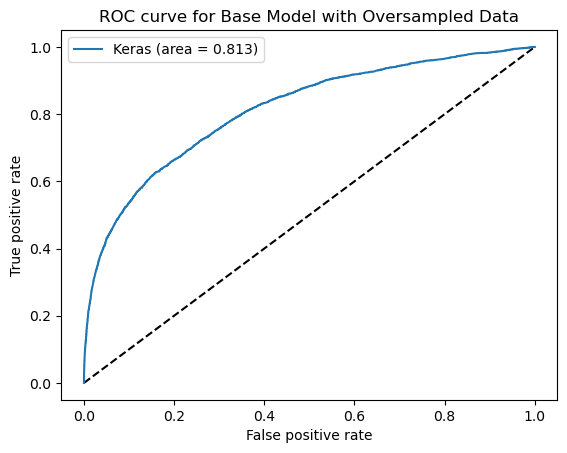

In [82]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras_smote))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Base Model with Oversampled Data')
plt.legend(loc='best')
plt.show()

In [83]:
temp = X_test.copy()
temp['predicted'] = y_pred
temp['true'] = y_test
fraud_cases = temp[temp['true'] == 1]
non_fraud_cases = temp[temp['true']==0]

In [84]:
temp.head()

,ProductCD,card3,card4,card6,addr2,R_emaildomain,D12,D13,M1,M2,M3,M4,M5,M7,M8,M9,V18,V30,V40,V60,V70,V80,V81,V91,V173,V174,V223,id_12,id_13,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_33,id_35,id_36,id_37,DeviceType,DeviceInfo,R_parent_domain,R_domain_name,R_top_level_domain,device_name,device_version,os_name,os_version,TransactionAmt,predicted,true
7681,1,42,4,1,65,31,-1.416108,-1.819843,2,2,2,3,2,2,2,2,-0.540222,-0.664176,-0.504170,-0.519610,-0.664404,-0.521953,-0.508172,-0.694394,-1.102703,-1.135389,-1.072947,1,54,0,0,59,389,51,0,0,16,132,1,0,1,0,1769,16,24,8,6,293,3,5,-0.460052,0.000088,0
570242,4,42,2,2,65,31,0.614603,0.533902,1,1,1,0,0,0,0,0,-0.540222,-0.664176,-0.504170,-0.519610,-0.664404,-0.521953,-0.508172,-0.694394,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.075376,0.417885,0
340470,0,73,2,1,43,19,-0.801775,0.533902,2,2,2,2,2,2,2,2,-0.540222,-0.664176,-0.504170,-0.519610,-0.664404,-0.521953,-0.508172,-0.694394,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,15,17,2,13,293,7,68,-0.256120,0.571607,0
131781,2,42,4,1,65,1,0.614603,-1.833103,2,2,2,3,2,2,2,2,1.683197,-0.664176,2.095003,1.524002,-0.664404,1.464129,1.372312,-0.694394,-1.102703,-1.135389,-1.072947,1,38,1,1,59,227,125,1,1,56,14,1,0,1,2,1727,1,1,2,12,293,6,11,1.107920,0.018653,0
472772,4,42,4,2,65,31,0.614603,0.533902,1,1,1,3,2,0,1,1,-0.540222,1.202141,-0.504170,-0.519610,1.204801,-0.521953,-0.508172,1.128298,0.892322,0.854764,0.815741,2,54,3,2,104,522,394,2,2,74,260,2,2,2,1,1735,16,24,8,13,293,7,68,-0.430993,0.086910,0


In [ ]:
# per row consider apakah dia tp, fp, fn, tn dengan bikin 4 kolom
# group by bin
# dihitung cumulative sum untuk setiap tp fp fn tn
# ini berubah seiring threshold berubah
# non-cumulative ngitung precision itu di bin itu doang (bins nya adalah populasi)
# fraud rate
# masukin y_val
# transaksi masuk, kemungkinan dia dihitung fraud berapa? -> fraud rate

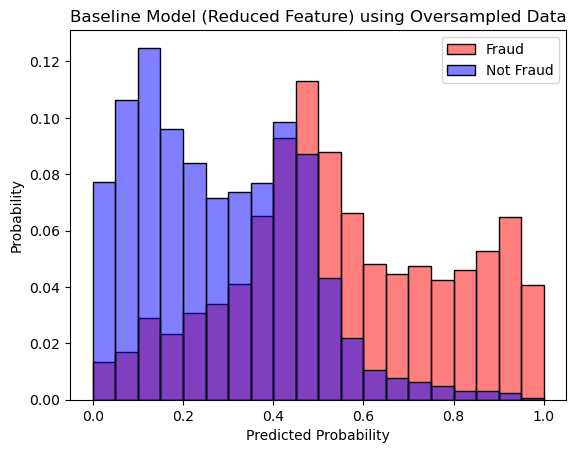

In [85]:
fig, ax = plt.subplots()
sns.histplot(data=fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='red', alpha=0.5, label='Fraud')
sns.histplot(data=non_fraud_cases, x='predicted', binwidth=0.05, binrange=[0,1], stat='probability', color='blue', alpha=0.5, label='Not Fraud')
plt.title("Baseline Model (Reduced Feature) using Oversampled Data")
plt.xlabel("Predicted Probability")
ax.legend()
plt.show()

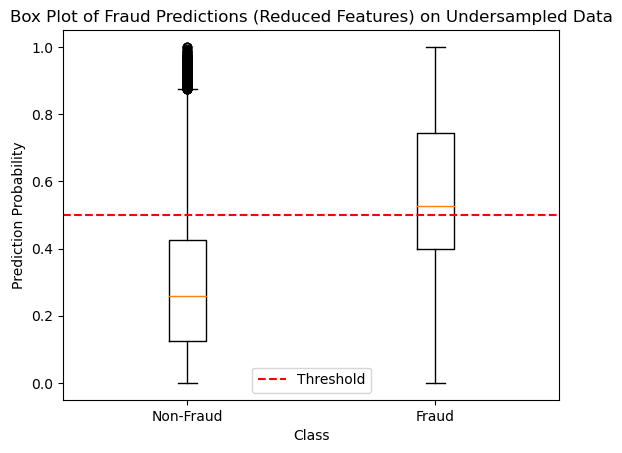

In [87]:
fraud_cases = y_pred[y_test==1]
non_fraud_cases = y_pred[y_test==0]
threshold = 0.5
plt.boxplot([non_fraud_cases.flatten(), fraud_cases.flatten()])
plt.xticks([1, 2], ['Non-Fraud', 'Fraud'])
plt.ylabel('Prediction Probability')
plt.xlabel('Class')
plt.title('Box Plot of Fraud Predictions (Reduced Features) on Undersampled Data')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

Based on this, we can decide that the threshold is 0.39. Let's calculate the confusion matrix

Threshold: 0.41


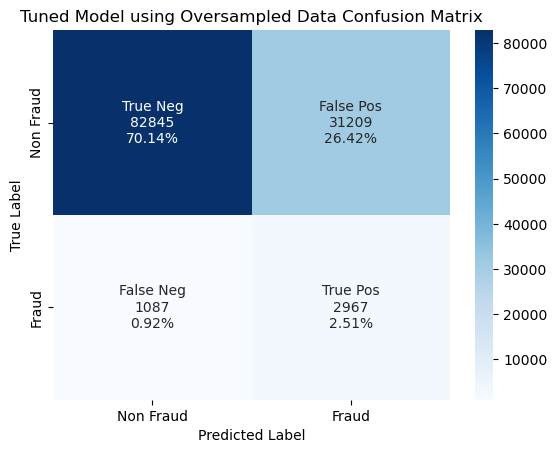

Metrics when threshold is 0.41: 
False Positive Rate: 0.27363354200641804
Recall: 0.7318697582634435
Precision: 0.08681530898876405
Accuracy: 0.7265553561147424
F1: 0.1552184148574418
AUC: 0.8126203001029579
Threshold: 0.42


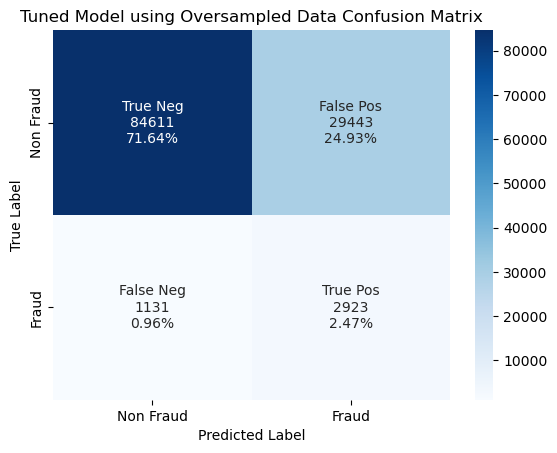

Metrics when threshold is 0.42: 
False Positive Rate: 0.25814964841215565
Recall: 0.7210162802170695
Precision: 0.09031081999629241
Accuracy: 0.7411352321603956
F1: 0.16051619989017024
AUC: 0.8126203001029579
Threshold: 0.43


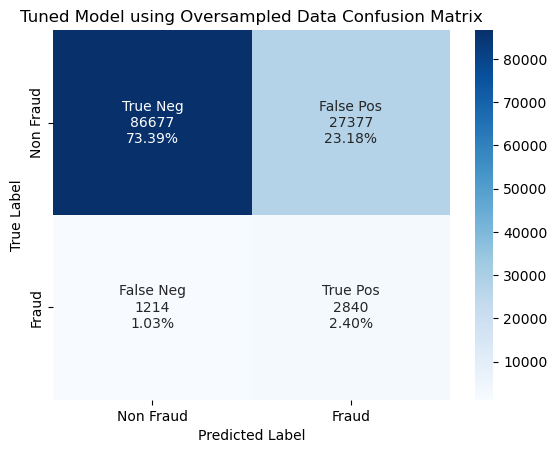

Metrics when threshold is 0.43: 
False Positive Rate: 0.24003542181773546
Recall: 0.7005426739023187
Precision: 0.09398682860641361
Accuracy: 0.7579249500457209
F1: 0.16573779580403256
AUC: 0.8126203001029579
Threshold: 0.44


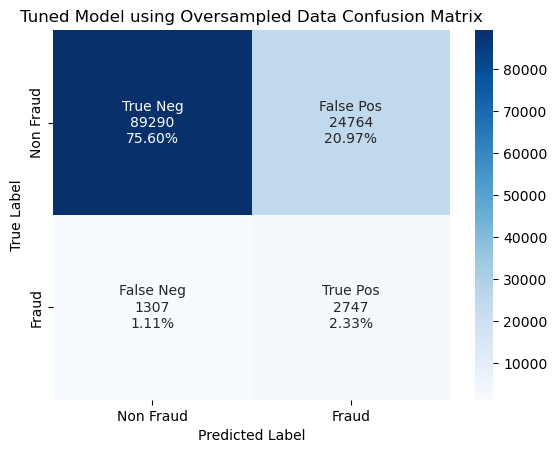

Metrics when threshold is 0.44: 
False Positive Rate: 0.21712522138636084
Recall: 0.6776023680315738
Precision: 0.09985096870342772
Accuracy: 0.7792613540149693
F1: 0.17405354031363854
AUC: 0.8126203001029579
Threshold: 0.45


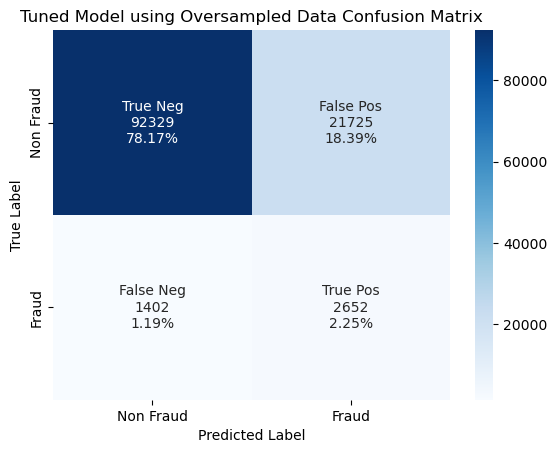

Metrics when threshold is 0.45: 
False Positive Rate: 0.19047994809476212
Recall: 0.65416872224963
Precision: 0.10879107355293925
Accuracy: 0.8041876926203136
F1: 0.18655692729766804
AUC: 0.8126203001029579
Threshold: 0.46


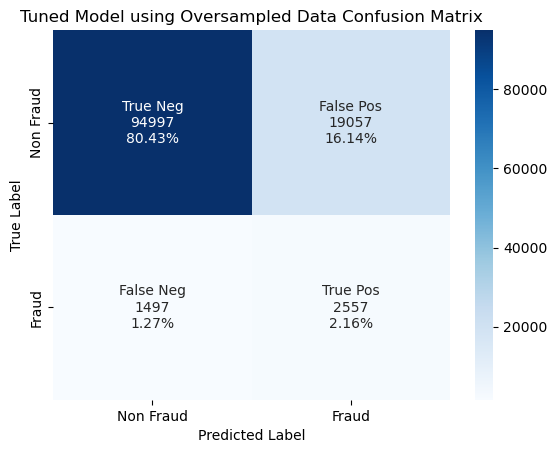

Metrics when threshold is 0.46: 
False Positive Rate: 0.1670875199466919
Recall: 0.6307350764676862
Precision: 0.11830295179050615
Accuracy: 0.8259728384190741
F1: 0.1992364033037245
AUC: 0.8126203001029579
Threshold: 0.47


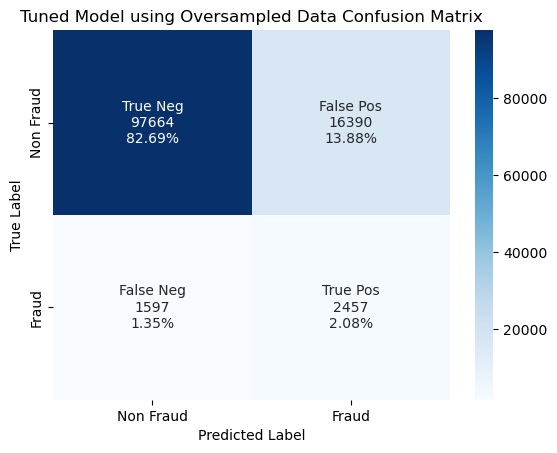

Metrics when threshold is 0.47: 
False Positive Rate: 0.1437038595752889
Recall: 0.6060680809077454
Precision: 0.13036557542314425
Accuracy: 0.847707183256003
F1: 0.2145757827169119
AUC: 0.8126203001029579
Threshold: 0.48


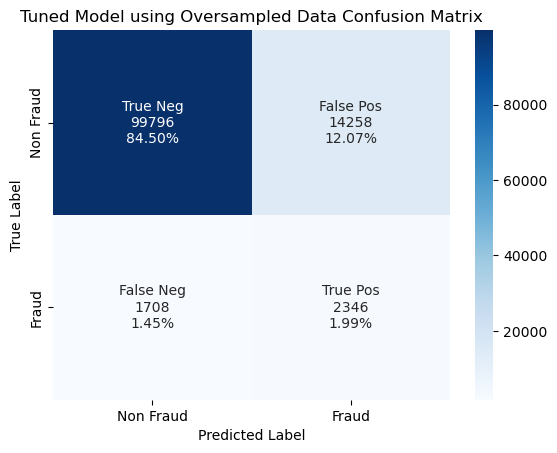

Metrics when threshold is 0.48: 
False Positive Rate: 0.12501095972083398
Recall: 0.5786877158362111
Precision: 0.14129125511924837
Accuracy: 0.8648186405662613
F1: 0.22712750508277665
AUC: 0.8126203001029579
Threshold: 0.49


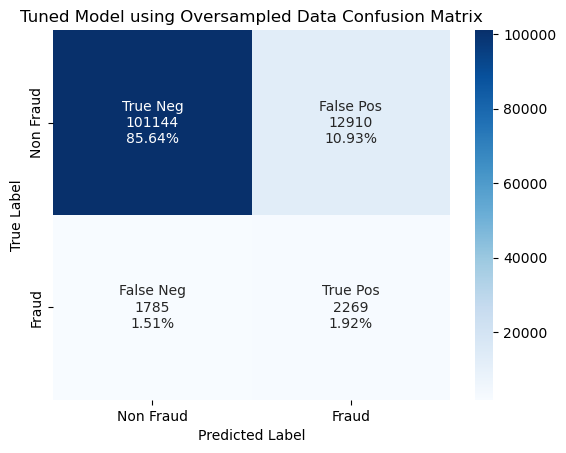

Metrics when threshold is 0.49: 
False Positive Rate: 0.11319199677345819
Recall: 0.5596941292550567
Precision: 0.14948283813162921
Accuracy: 0.8755799776475768
F1: 0.23594862995892474
AUC: 0.8126203001029579
Threshold: 0.5


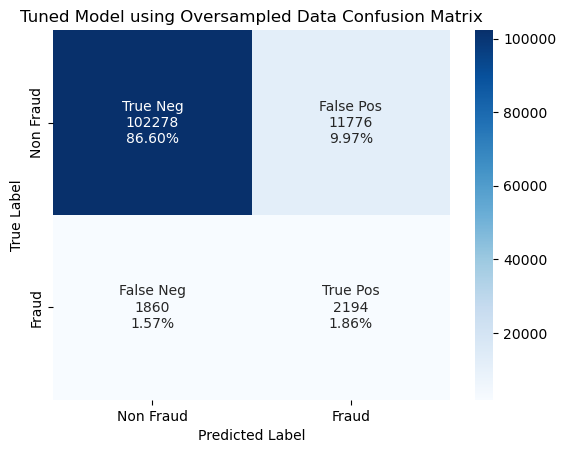

Metrics when threshold is 0.5: 
False Positive Rate: 0.10324933803286163
Recall: 0.5411938825851011
Precision: 0.15705082319255548
Accuracy: 0.8845463474108443
F1: 0.2434531735463826
AUC: 0.8126203001029579
Threshold: 0.51


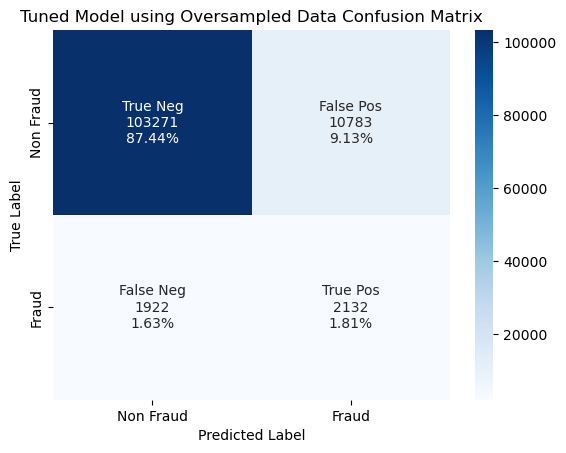

Metrics when threshold is 0.51: 
False Positive Rate: 0.09454293580233925
Recall: 0.5259003453379378
Precision: 0.16507936507936508
Accuracy: 0.8924289633217055
F1: 0.25128174907183687
AUC: 0.8126203001029579
Threshold: 0.52


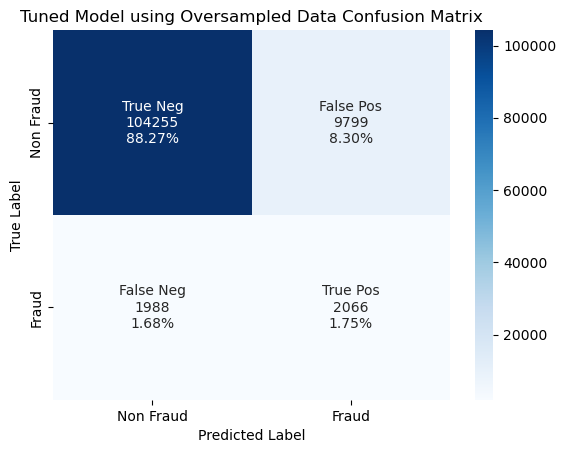

Metrics when threshold is 0.52: 
False Positive Rate: 0.0859154435618216
Recall: 0.5096201282683769
Precision: 0.17412557943531395
Accuracy: 0.9002015104819318
F1: 0.2595640429675231
AUC: 0.8126203001029579
Threshold: 0.53


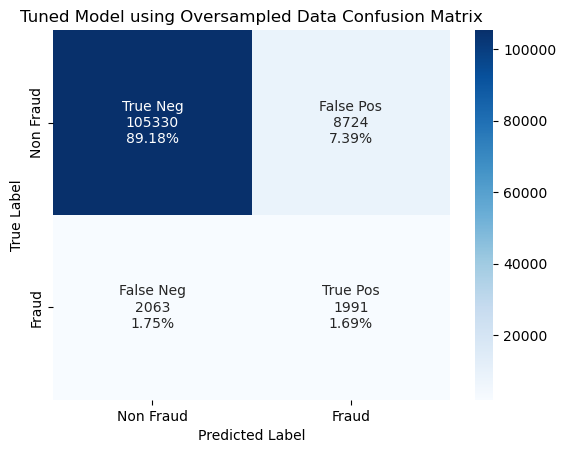

Metrics when threshold is 0.53: 
False Positive Rate: 0.07649008364458941
Recall: 0.4911198815984213
Precision: 0.18581427904806347
Accuracy: 0.9086683374538558
F1: 0.2696187961270229
AUC: 0.8126203001029579
Threshold: 0.54


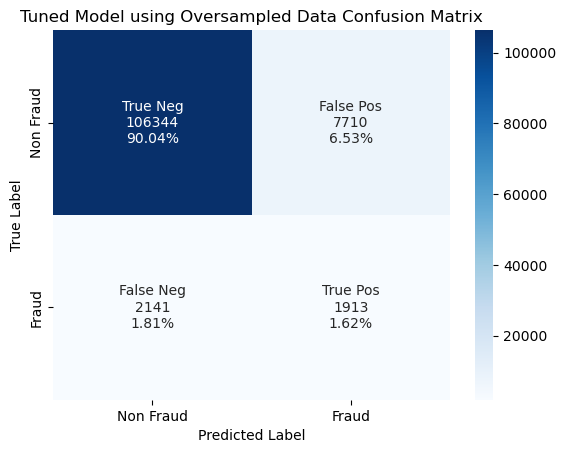

Metrics when threshold is 0.54: 
False Positive Rate: 0.06759955810405598
Recall: 0.4718796250616675
Precision: 0.19879455471266758
Accuracy: 0.9165932874995767
F1: 0.27973970900051176
AUC: 0.8126203001029579
Threshold: 0.55


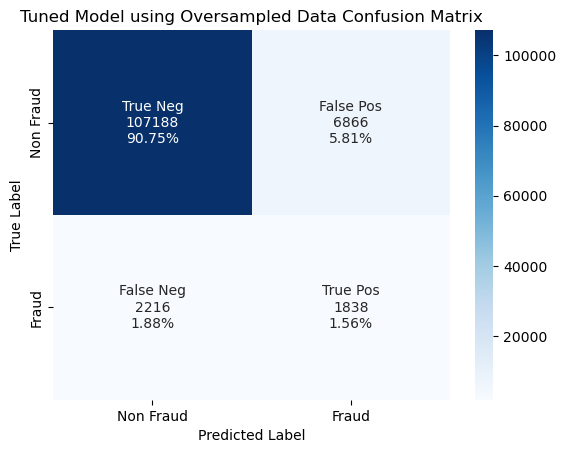

Metrics when threshold is 0.55: 
False Positive Rate: 0.06019955459694531
Recall: 0.4533793783917119
Precision: 0.21116727941176472
Accuracy: 0.9231042774409862
F1: 0.28813293619689606
AUC: 0.8126203001029579


In [88]:
import pandas as pd
threshold = [0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55]
results = []

for thresh in threshold:
    print(f"Threshold: {thresh}")
    y_pred_binary = (y_pred > thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.title("Tuned Model using Oversampled Data Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Non Fraud', 'Fraud'])
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    print(f"Metrics when threshold is {thresh}: ")

    print(f"False Positive Rate: {fpr}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1: {f1}")
    print(f"AUC: {auc_keras_smote}")
    print("="*80)
    
    result = {
        'Threshold': thresh,
        'False Positive Rate': fpr,
        'Recall': recall,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1,
        'AUC': auc_keras_smote
    }
    results.append(result)

df_result_smote = pd.DataFrame(results)


In [89]:
df_result_smote

,Threshold,False Positive Rate,Recall,Precision,Accuracy,F1,AUC
0,0.41,0.273634,0.731870,0.086815,0.726555,0.155218,0.81262
1,0.42,0.258150,0.721016,0.090311,0.741135,0.160516,0.81262
2,0.43,0.240035,0.700543,0.093987,0.757925,0.165738,0.81262
3,0.44,0.217125,0.677602,0.099851,0.779261,0.174054,0.81262
4,0.45,0.190480,0.654169,0.108791,0.804188,0.186557,0.81262
5,0.46,0.167088,0.630735,0.118303,0.825973,0.199236,0.81262
6,0.47,0.143704,0.606068,0.130366,0.847707,0.214576,0.81262
7,0.48,0.125011,0.578688,0.141291,0.864819,0.227128,0.81262
8,0.49,0.113192,0.559694,0.149483,0.875580,0.235949,0.81262
9,0.50,0.103249,0.541194,0.157051,0.884546,0.243453,0.81262


In [90]:
df_result_rus

,Threshold,False Positive Rate,Recall,Precision,Accuracy,F1,AUC
0,0.41,0.256273,0.611495,0.078182,0.739188,0.138639,0.743503
1,0.42,0.235704,0.589788,0.081677,0.758306,0.143483,0.743503
2,0.43,0.201878,0.553527,0.088804,0.789726,0.153054,0.743503
3,0.44,0.197406,0.545387,0.089420,0.793765,0.153648,0.743503
4,0.45,0.195609,0.542181,0.089685,0.795391,0.153911,0.743503
5,0.46,0.194627,0.539467,0.089686,0.796246,0.153803,0.743503
6,0.47,0.193601,0.538727,0.090006,0.797211,0.154243,0.743503
7,0.48,0.192637,0.538481,0.090378,0.798134,0.154779,0.743503
8,0.49,0.191427,0.537000,0.090671,0.799252,0.155145,0.743503
9,0.50,0.189971,0.533547,0.090768,0.800538,0.155143,0.743503


In [91]:
df_result_smote.to_csv('hasil baseline smote threshold.csv')
df_result_rus.to_csv('hasil baseline rus threshold.csv')